In [ ]:
!pip install tensorflow_addons

In [ ]:
import tensorflow as tf
import datetime
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import pickle
from pathlib import Path
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
from tensorflow import keras
from keras import Sequential, Model
from keras.layers import Dense, Dropout, Activation, \
Flatten, Input, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D,BatchNormalization, Dropout, add
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

from keras.metrics import CategoricalAccuracy, Recall, Precision
from tensorflow_addons.metrics import F1Score

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32

In [ ]:
LABELS = ["ForwardFall", "BackwardFall", "LeftFall", "RightFall", "GetDown", "SitDown", "Walk"]
LABEL2INDEX = dict(zip(LABELS, range(len(LABELS))))
INDEX2LABEL = dict(zip(range(len(LABELS)), LABELS))

In [ ]:
def residual_block(x, filters, kernel_size=(3, 3), strides=(1, 1), activation='relu', dropout_rate=0.5):
    y = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation(activation)(y)

    y = Conv2D(filters, kernel_size, padding='same')(y)
    y = BatchNormalization()(y)

    # Skip connection
    if strides != (1, 1) or x.shape[-1] != filters:
        x = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(x)
        x = BatchNormalization()(x)

    y = add([x, y])
    y = Activation(activation)(y)
    y = Dropout(dropout_rate)(y)
    return y

def build_model(img_height=IMAGE_HEIGHT, img_width=IMAGE_WIDTH, initial_filter=2**5, num_classes=7):
    inputs = Input(shape=(img_height, img_width, 1))
    x = Conv2D(initial_filter, (3, 3), padding='same')(inputs)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    # Stack residual blocks
    x = residual_block(x, initial_filter)
    x = MaxPooling2D((2, 2))(x)
    x = residual_block(x, initial_filter * 2)
    x = MaxPooling2D((2, 2))(x)
    x = residual_block(x, initial_filter * 2**2)

    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    x = Dense(50, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(optimizer = tf.keras.optimizers.Adadelta(learning_rate=1, rho=0.95, epsilon=1e-08, weight_decay=0.0),
                loss='categorical_crossentropy',
                metrics=[
                     CategoricalAccuracy(name='categorical_acc'),
                    Precision(name='precision'),
                    Recall(name='recall'),
                    F1Score(num_classes=num_classes, average='weighted', name='f1')
                ])

    return model

In [ ]:
def load_dataset(ds_name):
  with open(ds_name + '/element_spec', 'rb') as in_:
    es = pickle.load(in_)

  dataset = tf.data.Dataset.load(
      ds_name, es, compression='GZIP'
  )
  return dataset

# 7 labels

In [ ]:
train_ds = load_dataset("train")
val_ds = load_dataset("val")
test_ds = load_dataset("test")

In [ ]:
train_size = len(train_ds)
val_size = len(val_ds)
test_size = len(test_ds)
print(f'Train Size: {train_size}\nValidation Size: {val_size}\nTest Size: {test_size}')

Train Size: 65399
Validation Size: 26174
Test Size: 17182


In [ ]:
def one_hot_encode_label(label):
  label = tf.cast(label, dtype=tf.int32)
  return tf.one_hot(label, depth=7)

def process_image(image):
  image = image/255.0
  return image

train_ds = train_ds.map(lambda x, y: (process_image(x), one_hot_encode_label(y)))
val_ds = val_ds.map(lambda x, y: (process_image(x), one_hot_encode_label(y)))
test_ds = test_ds.map(lambda x, y: (process_image(x), one_hot_encode_label(y)))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().batch(batch_size=2**10).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().batch(batch_size=2**10).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().batch(batch_size=2**10).prefetch(buffer_size=AUTOTUNE)

In [ ]:
cnn_model = build_model(num_classes=7)
cnn_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 32, 32, 32)           320       ['input_2[0][0]']             
                                                                                                  
 activation_7 (Activation)   (None, 32, 32, 32)           0         ['conv2d_9[0][0]']            
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)           0         ['activation_7[0][0]']        
 g2D)                                                                                       

In [ ]:
today = str(datetime.date.today())
f1_modelcheckpoint_callback = ModelCheckpoint(
    today + 'resnet_model',
    monitor='val_f1',
    verbose=1,
    save_best_only=True,
    mode='max'
)

f1_early_stopping_callback = EarlyStopping(
    monitor='val_f1',
    patience=5,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = cnn_model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[
        f1_modelcheckpoint_callback,
        f1_early_stopping_callback
    ]
)

Epoch 1/30
64/64 [==============================] - ETA: 0s - loss: 1.7425 - categorical_acc: 0.3806 - precision: 0.4519 - recall: 0.2273 - f1: 0.3757
Epoch 1: val_f1 improved from -inf to 0.03902, saving model to 2024-04-14resnet_model
64/64 [==============================] - 10s 165ms/step - loss: 1.7425 - categorical_acc: 0.3806 - precision: 0.4519 - recall: 0.2273 - f1: 0.3757 - val_loss: 2.4676 - val_categorical_acc: 0.1498 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0390
Epoch 2/30
64/64 [==============================] - ETA: 0s - loss: 1.5727 - categorical_acc: 0.4307 - precision: 0.5091 - recall: 0.2749 - f1: 0.4256
Epoch 2: val_f1 improved from 0.03902 to 0.08900, saving model to 2024-04-14resnet_model
64/64 [==============================] - 13s 200ms/step - loss: 1.5727 - categorical_acc: 0.4307 - precision: 0.5091 - recall: 0.2749 - f1: 0.4256 - val_loss: 2.5621 - val_categorical_acc: 0.1942 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1

dict_keys(['loss', 'categorical_acc', 'precision', 'recall', 'f1', 'val_loss', 'val_categorical_acc', 'val_precision', 'val_recall', 'val_f1'])


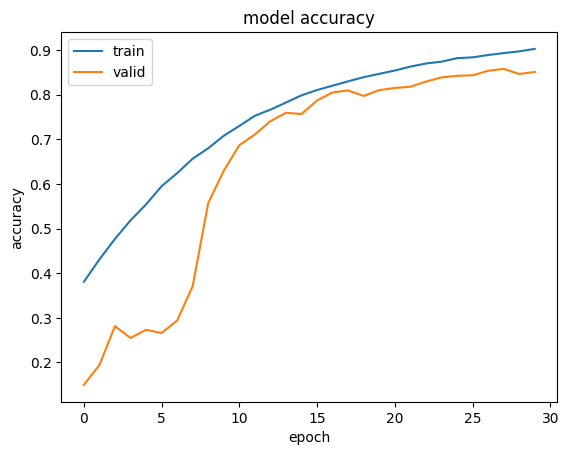

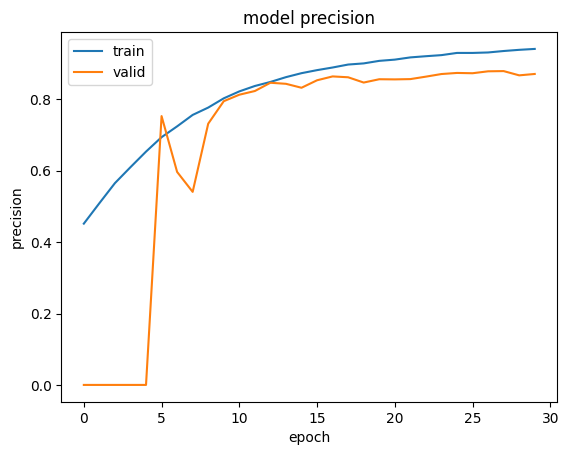

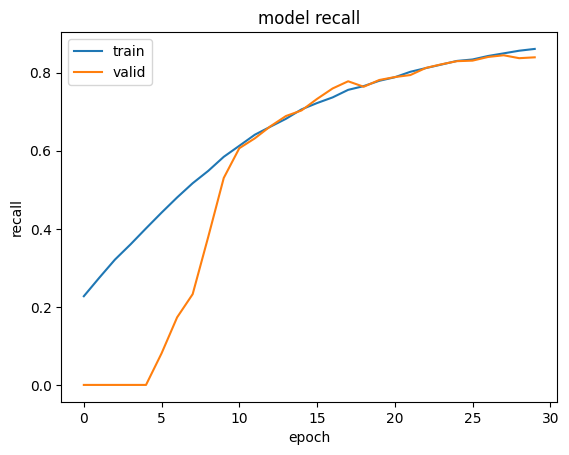

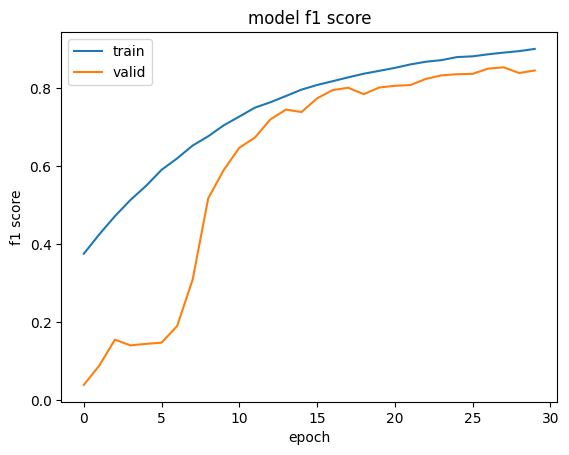

In [ ]:
print(history.history.keys())
plt.plot(history.history['categorical_acc'])
plt.plot(history.history['val_categorical_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()



plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()



plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
print(cnn_model.evaluate(val_ds))

26/26 [==============================] - 1s 24ms/step - loss: 0.5295 - categorical_acc: 0.8507 - precision: 0.8713 - recall: 0.8394 - f1: 0.8460
[0.5294898152351379, 0.8506914973258972, 0.8712773323059082, 0.8394207954406738, 0.8459703922271729]


In [ ]:
print(cnn_model.evaluate(test_ds))

17/17 [==============================] - 3s 165ms/step - loss: 0.4836 - categorical_acc: 0.8559 - precision: 0.8906 - recall: 0.8487 - f1: 0.8471
[0.4835508167743683, 0.8558956980705261, 0.8906192779541016, 0.8487370610237122, 0.847143292427063]


In [ ]:
y_pred = []
y_true = []

for image_batch, label_batch in val_ds:
   y_true.append(label_batch)
   preds = cnn_model.predict(image_batch, verbose=0)
   y_pred.append(np.argmax(preds, axis = - 1))

correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
import pandas as pd
conf_matrix = confusion_matrix(tf.math.argmax(correct_labels, axis=1), predicted_labels.numpy())
confusion_df = pd.DataFrame(conf_matrix, index=LABELS, columns=LABELS)
display(confusion_df)
f1_score(tf.math.argmax(correct_labels, axis=1), predicted_labels.numpy(), average=None)

,ForwardFall,BackwardFall,LeftFall,RightFall,GetDown,SitDown,Walk
ForwardFall,3765,243,0,0,7,0,0
BackwardFall,758,2151,590,416,5,0,0
LeftFall,0,0,2865,571,0,98,0
RightFall,0,0,121,3485,0,0,0
GetDown,0,0,0,0,3614,0,0
SitDown,0,0,0,12,363,3210,0
Walk,0,0,156,0,568,0,3176


array([0.88193956, 0.68134305, 0.78860446, 0.86155748, 0.88459185,
       0.93137966, 0.89768231])

# 2 labels

In [ ]:
train_ds = load_dataset("train")
val_ds = load_dataset("val")
test_ds = load_dataset("test")

In [ ]:
def process_image(image):
  image = image/255.0
  return image

def one_hot_encode_label(label):
  label = tf.cast(label, dtype=tf.int32)
  label = int(label<=3)
  return tf.one_hot(label, depth=2)

train_ds = train_ds.map(lambda x, y: (process_image(x), one_hot_encode_label(y)))
val_ds = val_ds.map(lambda x, y: (process_image(x), one_hot_encode_label(y)))
test_ds = test_ds.map(lambda x, y: (process_image(x), one_hot_encode_label(y)))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().batch(batch_size=2**10).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().batch(batch_size=2**10).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().batch(batch_size=2**10).prefetch(buffer_size=AUTOTUNE)

In [ ]:
cnn_model = build_model(num_classes=2)
cnn_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_18 (Conv2D)          (None, 32, 32, 32)           320       ['input_3[0][0]']             
                                                                                                  
 activation_14 (Activation)  (None, 32, 32, 32)           0         ['conv2d_18[0][0]']           
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 32)           0         ['activation_14[0][0]']       
 g2D)                                                                                       

In [ ]:
today = str(datetime.date.today())
f1_modelcheckpoint_callback = ModelCheckpoint(
    today + 'resnet_model',
    monitor='val_f1',
    verbose=1,
    save_best_only=True,
    mode='max'
)

f1_early_stopping_callback = EarlyStopping(
    monitor='val_f1',
    patience=5,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = cnn_model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[
        f1_modelcheckpoint_callback,
        f1_early_stopping_callback,
    ]
)

Epoch 1/30
64/64 [==============================] - ETA: 0s - loss: 0.5132 - categorical_acc: 0.8067 - precision: 0.8067 - recall: 0.8067 - f1: 0.8077
Epoch 1: val_f1 improved from -inf to 0.25254, saving model to 2024-04-14resnet_model
64/64 [==============================] - 11s 174ms/step - loss: 0.5132 - categorical_acc: 0.8067 - precision: 0.8067 - recall: 0.8067 - f1: 0.8077 - val_loss: 1.2464 - val_categorical_acc: 0.4240 - val_precision: 0.4240 - val_recall: 0.4240 - val_f1: 0.2525
Epoch 2/30
64/64 [==============================] - ETA: 0s - loss: 0.4455 - categorical_acc: 0.8380 - precision: 0.8380 - recall: 0.8380 - f1: 0.8387
Epoch 2: val_f1 did not improve from 0.25254
64/64 [==============================] - 5s 76ms/step - loss: 0.4455 - categorical_acc: 0.8380 - precision: 0.8380 - recall: 0.8380 - f1: 0.8387 - val_loss: 1.2042 - val_categorical_acc: 0.4240 - val_precision: 0.4240 - val_recall: 0.4240 - val_f1: 0.2525
Epoch 3/30
64/64 [==============================] - E

dict_keys(['loss', 'categorical_acc', 'precision', 'recall', 'f1', 'val_loss', 'val_categorical_acc', 'val_precision', 'val_recall', 'val_f1'])


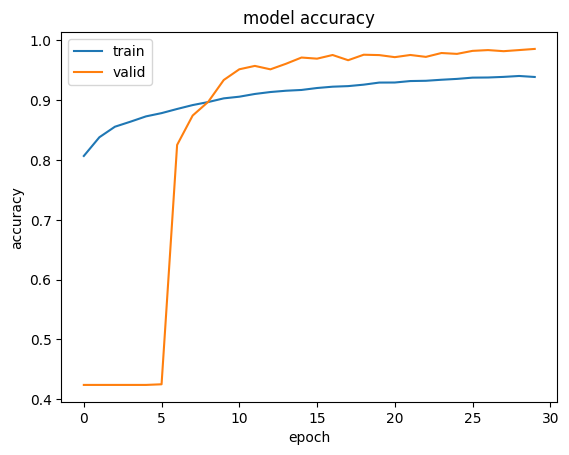

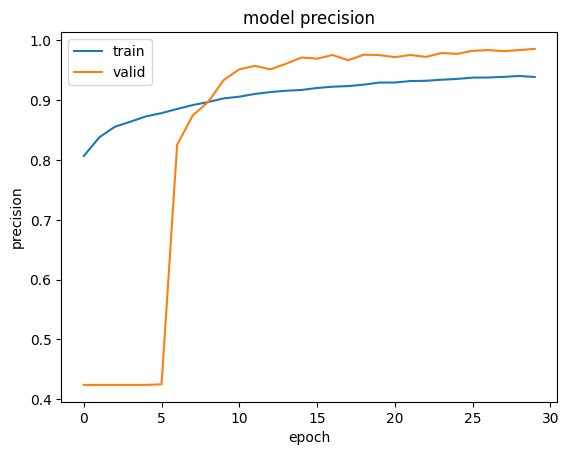

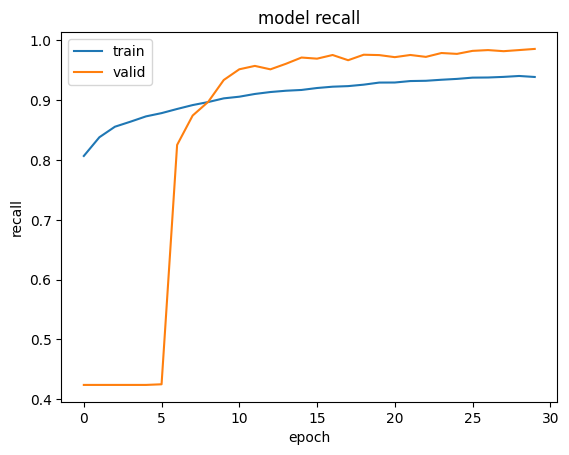

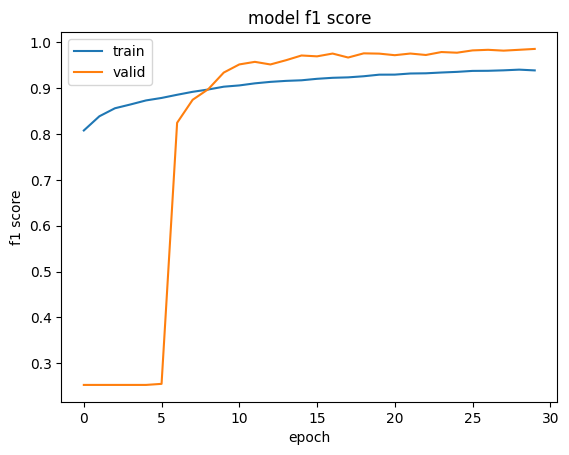

In [ ]:
print(history.history.keys())
plt.plot(history.history['categorical_acc'])
plt.plot(history.history['val_categorical_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()



plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()



plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
print(cnn_model.evaluate(val_ds))

26/26 [==============================] - 1s 21ms/step - loss: 0.0531 - categorical_acc: 0.9856 - precision: 0.9856 - recall: 0.9856 - f1: 0.9857
[0.053119584918022156, 0.9856346249580383, 0.9856346249580383, 0.9856346249580383, 0.9856633543968201]


In [ ]:
print(cnn_model.evaluate(test_ds))

17/17 [==============================] - 2s 91ms/step - loss: 0.0510 - categorical_acc: 0.9790 - precision: 0.9790 - recall: 0.9790 - f1: 0.9790
[0.05102461203932762, 0.9789896607398987, 0.9789896607398987, 0.9789896607398987, 0.9790284633636475]


In [ ]:
y_pred = []
y_true = []

for image_batch, label_batch in test_ds:
   y_true.append(label_batch)
   preds = cnn_model.predict(image_batch, verbose=0)
   y_pred.append(np.argmax(preds, axis = - 1))

correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
import pandas as pd
conf_matrix = confusion_matrix(tf.math.argmax(correct_labels, axis=1), predicted_labels.numpy())
confusion_df = pd.DataFrame(conf_matrix, index=["Not Fall", "Fall"], columns=["Not Fall", "Fall"])
display(confusion_df)
f1_score(tf.math.argmax(correct_labels, axis=1), predicted_labels.numpy(), average=None)

,Not Fall,Fall
Not Fall,7661,0
Fall,361,9160


array([0.97698144, 0.98067555])